In [32]:
import os
import numpy as np
import pandas as pd
import random
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

In [33]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [34]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=compute_rgb(color), thickness=thickness)
    
    return image

In [35]:
def compute_rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [36]:
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

In [37]:
rgb = True

if(rgb==True):
    path_rgb = "rgb"
else:
    path_rgb="intensity"

In [38]:
DATASET_NUMBER = 1

AUGMENTED_DATASET_PATH = "../augmented_dataset"
WAFER_CROPPED_PATH = f"{AUGMENTED_DATASET_PATH}/wafer_{path_rgb}_cropped_{str(DATASET_NUMBER)}"


### Cropped Section Example

In [39]:
path_img= f"{WAFER_CROPPED_PATH}/extract/0.tif"
if os.path.isfile(path_img):
    if(rgb==True):
        section = cv.imread(path_img)
    else:
        section = cv.imread(path_img,0)
else:
    print ("The file " + path_img + " does not exist.")

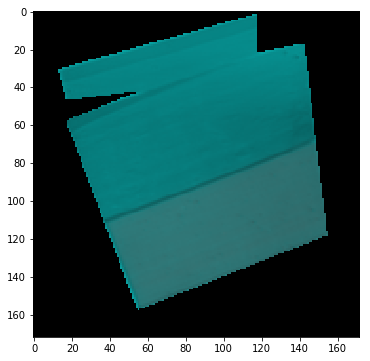

In [40]:
plt.figure(figsize=(8, 6))
plt.imshow(section)

In [41]:
section.shape

(172, 172, 3)

In [42]:
height_section = section.shape[0]
width_section = section.shape[1]

In [43]:
if(rgb==True):
    init_img = np.zeros([height_section,width_section,3],dtype=np.uint8)
else:
    init_img = np.zeros([height_section,width_section],dtype=np.uint8)
sub = init_img

In [44]:
if(rgb==True):
    test_section = np.mean(section,axis=2)
else:
    test_section = section

In [45]:
# Boolean matrix which is true is not 0 (the pixel has a value, and is the potentially the object)
ind_true = test_section > 0

In [46]:
for i in range(height_section):
    for j in range(width_section):
        if(ind_true[i,j] == True):
            sub[i,j] = section[i,j]
        else:
            if(rgb==True):
                sub[i,j] = [0,0,0]
            else:
                sub[i,j] = 0

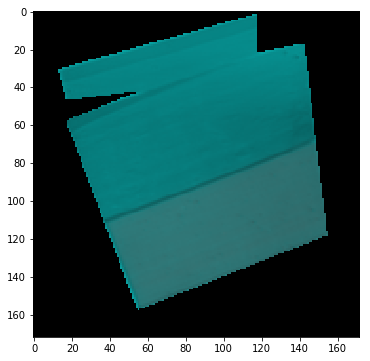

In [47]:
plt.figure(figsize=(8, 6))

plt.imshow(sub)

### Load Segmentation Boxes 

To create artificial image we will load section with the associated segmentation boxes coordinates. 
In this example we're working only with the dataset1. Hence we load the seg. boxes for the dataset1.

In [48]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

In [104]:
seg_coord_tissues = pd.read_csv(f"{WAFER_CROPPED_PATH}/boxes_tissues.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_tissues_dataset1.head()

point_1      point_2     point_3     point_4    
        x    y       x   y       x   y       x   y
0      36  110      16  58     142  16     148  67
1      40  114      16  64     141  16     150  65
2      38  110      16  59     143  16     149  66
3      45  126      16  78     132  16     147  66
4      44  123      16  75     136  16     148  65

In [105]:
seg_coord_mag = pd.read_csv(f"{WAFER_CROPPED_PATH}/boxes_mag.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_mag_dataset1.head()

point_1      point_2      point_3     point_4     
        x    y       x    y       x   y       x    y
0      55  156      37  112     148  68     156  118
1      61  160      42  117     149  67     160  114
2      58  156      39  111     150  67     158  115
3      71  171      46  128     146  66     163  113
4      68  166      44  124     148  66     162  113

### Collision Detection

Method able to check only the interesting part of a section (not the background) and output the 'collision boxes' for this section.
We'll then be able to compare these collision boxes to check whether the section will collide with other sections in the full image

In [51]:
def get_collision_boxes(orig_section,nb_boxes = 4, rgb=False, draw = False):
    #Divide the section into 5 block 
    if(rgb == True):
        section = np.mean(orig_section,axis=2)
    else:
        section = orig_section
    
    height_section = section.shape[0]
    width_section = section.shape[1]
    

    limit_boxes = np.zeros([nb_boxes,4],dtype=np.uint16)
    
    cut_height = (height_section//nb_boxes)+1
    for cuts in range(nb_boxes):
        i=0

        if((cuts)*cut_height + 4 >= height_section):
            limit_boxes[cuts] = limit_boxes[cuts-1]
        
        else:
            ymax_box = (cuts+1)*cut_height
            if(ymax_box >= height_section):
                ymax_box = height_section-1
                temp_cut_height = height_section - cut_height*(cuts)
            else:
                temp_cut_height = cut_height
            
            
            # y Min
            for i in range(temp_cut_height):
                if( (np.mean( section[i + cuts*cut_height] ) != 0)):
                    limit_boxes[cuts,0] = i+cuts*cut_height
                    break
            # y Max

            for i in range(cut_height):
                if(np.mean(section[ymax_box-i-1]) != 0):
                    limit_boxes[cuts,1] = ymax_box-i
                    break
            # x Min
            for i in range(width_section):
                if( np.mean( section[ cuts*cut_height+1 : ymax_box , i] ) != 0):
                    limit_boxes[cuts,2] = i
                    break
            # x Max
            for i in range(width_section-1,0,-1):
                if(np.mean(section[cuts*cut_height+1:ymax_box,i]) != 0):
                    limit_boxes[cuts,3] = i
                    break

            # Prevent empty slices
            if(np.mean(limit_boxes[cuts]) == 0 ):
                limit_boxes[cuts] = limit_boxes[cuts - 1]
            if(limit_boxes[cuts,2] == limit_boxes[cuts,3] ):
                limit_boxes[cuts,3] = limit_boxes[cuts,3]+1
            
            for i in range(min(cuts,5)):
                if(np.mean(limit_boxes[cuts-(i+1)]) <= 1 ):
                    limit_boxes[cuts-(i+1)] = limit_boxes[cuts]
            

            
            if((limit_boxes[cuts,2] <= 1) and  (limit_boxes[cuts,3] <= 1)):
                limit_boxes[cuts] = limit_boxes[cuts - 1]
            

        
          
        if(draw):
            pts = np.array([limit_boxes[cuts,2],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,1], limit_boxes[cuts,2],limit_boxes[cuts,1] ] )
            pts = pts.reshape((-1,1,2))
            section = cv.polylines(section, np.int32([pts]), True, color=compute_rgb(tissue_color), thickness=1)
            plt.imshow(section)
    return limit_boxes
        

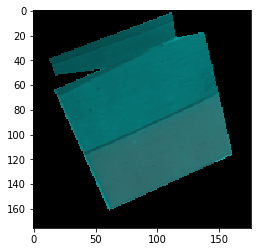

In [54]:
path_img= f"{WAFER_CROPPED_PATH}/extract/1.tif"
if(rgb==True):
    section = cv.imread(path_img)
else:
    section = cv.imread(path_img,0)
plt.imshow(section)

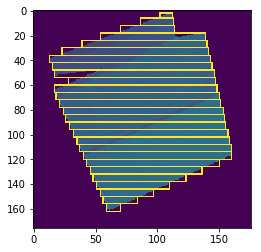

In [55]:
t = get_collision_boxes(section,30,rgb,True)

### Create Artificial Image

Extract randomly section and place it randomly in the image. For each section, compute and store the segmentation boxes coordinates of the section (brain + mag)

In [65]:
def generate_mask(image, points):
    # size of the image
    height = image.size[1]
    width = image.size[0]
    
    # init mask
    img_mask = np.zeros([height,width],dtype=np.uint8)
    img_mask.fill(0)
    
    cv.fillConvexPoly(img_mask, points, 255)
    
    return img_mask

In [73]:
def generate_artificial_batches(wafer, nb_batch, iter_img, DATASET_NUMBER, section_size ):
    
    index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])
    
    seg_tissues = pd.read_csv(temp_path_seg_tissues, sep="\t|,", header=None, names=index, engine='python')
    seg_mag = pd.read_csv(temp_path_seg_mag, sep="\t|,", header=None, names=index, engine='python')
    
    for i in range(1,nb_batch+1):


        # random crop coordinates (top-left point of the cropped area)
        start_x = random.randint(0, wafer.size[0] - section_size)
        start_y = random.randint(0, wafer.size[1] - section_size)

        # cropping the wafer image
        cropped_image = wafer.crop((start_x,start_y,start_x+section_size,start_y+section_size))


        # index of all tissue part within the cropped area
        tissue_indicies = list()
        for index, row in seg_tissues.iterrows(): # iterating over sections
            points_within = 0
            for j in range(0,8,2): # iterating over the 4 points for each section
                if (start_x < row[j]-5) &  (row[j] < start_x+section_size-5) & (start_y < row[j+1]-5) &  (row[j+1]< start_y+section_size-5):
                    points_within += 1
            if(points_within >= 1):
                tissue_indicies.append(index)

        # index of all magnetic part within the cropped area
        mag_indicies = list()
        for index, row in seg_mag.iterrows(): # iterating over sections
            points_within = 0
            for j in range(0,8,2): # iterating over the 4 points for each section
                if (start_x < row[j]-5) &  (row[j] < start_x+section_size-5) & (start_y < row[j+1]-5) &  (row[j+1]< start_y+section_size-5):
                    points_within += 1
            if(points_within >= 1):
                mag_indicies.append(index)


        if( (len(tissue_indicies) >=3) & (len(mag_indicies) >=3) ):

            # creating directories to store results
            image_folder = f"../augmented_dataset/stage1/artif{str(DATASET_NUMBER)}_{iter_img}_crop"+str(i)+"/image/" 
            os.makedirs(os.path.dirname(image_folder), exist_ok=True)
            tissue_masks_folder = f"../augmented_dataset/stage1/artif{str(DATASET_NUMBER)}_{iter_img}_crop"+str(i)+"/tissue_masks/" 
            os.makedirs(os.path.dirname(tissue_masks_folder), exist_ok=True)
            magnetic_masks_folder = f"../augmented_dataset/stage1/artif{str(DATASET_NUMBER)}_{iter_img}_crop"+str(i)+"/magnetic_masks/" 
            os.makedirs(os.path.dirname(magnetic_masks_folder), exist_ok=True)

            # creating tissue part mask
            ind_img = 0
            for section_index in tissue_indicies:
                vertices = np.array(seg_tissues.loc[[section_index]]).reshape((4, 2))
                #print(vertices)

                mask = generate_mask(wafer,vertices)
                _mask = Image.fromarray(np.uint8(mask))
                _mask = _mask.crop((start_x,start_y,start_x+section_size,start_y+section_size))


                # saving the cropped mask
                _mask.save(tissue_masks_folder+str(section_index)+".tif")
                ind_img = ind_img +1


            # creating magnetic part mask
            ind_img = 0
            for section_index in mag_indicies:
                vertices = np.array(seg_mag.loc[[section_index]], 'int32').reshape((4, 2))
                #print(vertices)

                mask = generate_mask(wafer,vertices)
                _mask = Image.fromarray(np.uint8(mask))
                _mask = _mask.crop((start_x,start_y,start_x+section_size,start_y+section_size))


                # saving the cropped mask
                _mask.save(magnetic_masks_folder+str(section_index)+".tif")
                ind_img = ind_img +1

            # saving the cropped image
            path_img_tosave = f"{image_folder}artif{str(DATASET_NUMBER)}_{iter_img}_crop{str(i)}.tif"
            cropped_image.save(path_img_tosave)
    

In [74]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_{path_rgb}_wafer{str(DATASET_NUMBER)}.tif"
if(rgb==True):
    backgnd = cv.imread(path_img)
else:
    backgnd = cv.imread(path_img,0)

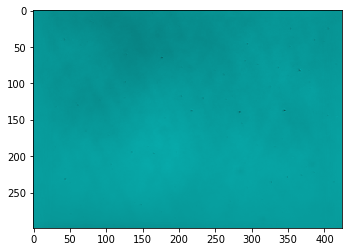

In [75]:
plt.imshow(backgnd)

In [76]:
# Size of the image
print(backgnd.shape)
grid_background = 4
height, width = backgnd.shape[0]*grid_background, backgnd.shape[1]*grid_background  # means 10x10 background images
print(height, width)

if(rgb==True):
    full_image = np.zeros([height, width,3],dtype=np.uint8)
else:
    full_image = np.zeros([height, width],dtype=np.uint8)
full_image.fill(0)

(299, 424, 3)
1196 1696


In [106]:
random.seed(22)

if(DATASET_NUMBER == 1):
    max_num_section = 100
elif(DATASET_NUMBER == 2):
    max_num_section = 35
else:
    max_num_section = 70
    
# Height and width of the resulting section in pixels
section_size = 512

# NB of artificial images to create
nb_artificial_images = 2

# Number of sections that will be generated
number_batches = 10

In [78]:
temp_path_seg_tissues = f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_tissues_artif.txt"
temp_path_seg_mag = f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_mag_artif.txt"

In [97]:
def check_avail_area(full_image,section,width, width_section, height, height_section, nb_collision_boxes, rgb):

    collision_boxes_section = get_collision_boxes(section, nb_collision_boxes, rgb, False)
    # Find an area in the image free (all pixels = 255)
    timeout = 0
    free_place = False
    while(free_place == False):
        xpos_section = random.randint(0, width - width_section- 1)
        ypos_section = random.randint(0, height - height_section - 1)

        free_place = True
        for i in range(nb_collision_boxes):
            #print(i)
            ymin = ypos_section+collision_boxes_section[i][0]
            ymax = ypos_section+collision_boxes_section[i][1]
            xmin = xpos_section+collision_boxes_section[i][2]
            xmax = xpos_section+collision_boxes_section[i][3]

            # check collision box 
            if(rgb==True):
                if(np.mean(np.mean(full_image[ymin:ymax, xmin:xmax],axis=2)) != 0):
                    free_place = False
            else:
                if(np.mean(full_image[ymin:ymax, xmin:xmax]) != 0):
                    free_place = False

        if(timeout>10000):
            # end loop no more space
            print("No more space")
            break
        else:
            timeout= timeout+1

    return xpos_section, ypos_section, free_place

In [108]:
res = create_artificial_images(0, DATASET_NUMBER, backgnd, grid_background, seg_coord_tissues, seg_coord_mag, rgb, max_num_section )

No more space
no space


In [103]:
def create_artificial_images(iter_img, DATASET_NUMBER, backgnd, grid_background, seg_coord_tissues, seg_coord_mag, rgb, max_num_section ):
    
    if(rgb==True):
        path_rgb = "rgb"
    else:
        path_rgb="intensity"
    
    AUGMENTED_DATASET_PATH = "../augmented_dataset"
    WAFER_CROPPED_PATH = f"{AUGMENTED_DATASET_PATH}/wafer_{path_rgb}_cropped_{str(DATASET_NUMBER)}"
    
    height, width = backgnd.shape[0]*grid_background, backgnd.shape[1]*grid_background 
    if(rgb==True):
        full_image = np.zeros([height, width,3],dtype=np.uint8)
    else:
        full_image = np.zeros([height, width],dtype=np.uint8)
    full_image.fill(0)  
    nb_sections = 120
    
    temp_path_seg_tissues = f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_tissues_artif.txt"
    temp_path_seg_mag = f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_mag_artif.txt"
    f_seg_tissues_artif = open(temp_path_seg_tissues,"w+")
    f_seg_mag_artif= open(temp_path_seg_mag,"w+")
    
    for index_section in range(nb_sections):

        # Section selection
        # section_num will be use to load the data image, and to load the corrects segmentation boxes
        
        section_num = random.randint(0, max_num_section)
        path_img= f"{WAFER_CROPPED_PATH}/extract/{str(section_num)}.tif"
        if(rgb==True):
            section = cv.imread(path_img)
        else:
            section = cv.imread(path_img,0)
        
        height_section = section.shape[0]
        width_section = section.shape[1]

        # Collision boxes to not interfere with other sections
        nb_collision_boxes = 40
        
        xpos_section, ypos_section, free_place = check_avail_area(full_image,section, width, width_section, height, height_section, nb_collision_boxes, rgb)
        
        if(free_place == False):
            # No more space
            break
            
        # Integrate the section into the full image
        for i in range(height_section):
            for j in range(width_section):
                if(rgb==True):
                    if(np.mean(section[i,j]) != 0):
                        full_image[ypos_section+i,xpos_section+j] = section[i,j]
                else:
                    if(section[i,j] != 0):
                        full_image[ypos_section+i,xpos_section+j] = section[i,j]
    
        #Store the new segmentation position Brain tissues in txt file
        temp_tissue = boxes_tissues_dataset1.iloc[section_num]
        write_coordinates_file(temp_tissue,xpos_section, ypos_section, f_seg_tissues_artif)

        #Store the new segmentation position Mag in txt file
        temp_mag = boxes_mag_dataset1.iloc[section_num]
        write_coordinates_file(temp_mag,xpos_section, ypos_section, f_seg_mag_artif)


    f_seg_tissues_artif.close()
    f_seg_mag_artif.close()
    
    # Add background
    width_subbckgnd = backgnd.shape[1]
    height_subbckgnd = backgnd.shape[0]

    for ind_y in range(grid_background):
        for ind_x in range(grid_background):

            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(np.mean(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j]) == 0):
                        full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
    
    return full_image

In [100]:
def write_coordinates_file(coordinate_section,xpos_section, ypos_section, file_towrite):
        
        seg_p1_x = coordinate_section['point_1']['x'] + xpos_section  
        seg_p1_y = coordinate_section['point_1']['y'] + ypos_section  

        seg_p2_x = coordinate_section['point_2']['x'] + xpos_section  
        seg_p2_y = coordinate_section['point_2']['y'] + ypos_section  

        seg_p3_x = coordinate_section['point_3']['x'] + xpos_section  
        seg_p3_y = coordinate_section['point_3']['y'] + ypos_section 

        seg_p4_x = coordinate_section['point_4']['x'] + xpos_section 
        seg_p4_y = coordinate_section['point_4']['y'] + ypos_section 

        file_towrite.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_p1_x,seg_p1_y,  seg_p2_x,seg_p2_y,  seg_p3_x,seg_p3_y,  seg_p4_x,seg_p4_y))


In [101]:
for iter_img in range(nb_artificial_images): 
    height, width = backgnd.shape[0]*grid_background, backgnd.shape[1]*grid_background 
    if(rgb==True):
        full_image = np.zeros([height, width,3],dtype=np.uint8)
    else:
        full_image = np.zeros([height, width],dtype=np.uint8)
    full_image.fill(0)  
    nb_sections = random.randint(90, 120)
    
    f_seg_tissues_artif = open(temp_path_seg_tissues,"w+")
    f_seg_mag_artif= open(temp_path_seg_mag,"w+")

    for index_section in range(nb_sections):

        # Section selection
        # section_num will be use to load the data image, and to load the corrects segmentation boxes
        
        section_num = random.randint(0, max_num_section)
        print(section_num)

        path_img= f"{WAFER_CROPPED_PATH}/extract/{str(section_num)}.tif"
        if(rgb==True):
            section = cv.imread(path_img)
        else:
            section = cv.imread(path_img,0)
        height_section = section.shape[0]
        width_section = section.shape[1]

 
        # Collision boxes to not interfere with other sections
        nb_collision_boxes = 40
        

        xpos_section, ypos_section, free_place = check_avail_area(full_image,section, width, width_section, height, height_section, nb_collision_boxes, rgb)
        
        if(free_place == False):
            # No more space
            print("no space")
            break
               


        # Integrate the section into the full image
        for i in range(height_section):
            for j in range(width_section):
                if(rgb==True):
                    if(np.mean(section[i,j]) != 0):
                        full_image[ypos_section+i,xpos_section+j] = section[i,j]
                else:
                    if(section[i,j] != 0):
                        full_image[ypos_section+i,xpos_section+j] = section[i,j]



        #Store the new segmentation position Brain tissues in txt file
        temp_tissue = boxes_tissues_dataset1.iloc[section_num]
        write_coordinates_file(temp_tissue,xpos_section, ypos_section, f_seg_tissues_artif)

        #Store the new segmentation position Mag in txt file
        temp_mag = boxes_mag_dataset1.iloc[section_num]
        write_coordinates_file(temp_mag,xpos_section, ypos_section, f_seg_mag_artif)


    f_seg_tissues_artif.close()
    f_seg_mag_artif.close()
    
    
    # Add background
    width_subbckgnd = backgnd.shape[1]
    height_subbckgnd = backgnd.shape[0]

    for ind_y in range(grid_background):
        for ind_x in range(grid_background):

            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(np.mean(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j]) == 0):
                        full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
      
    # Generate artificial batches
    if(rgb==True):
        wafer = Image.fromarray(np.uint8(full_image),'RGB')
    else:
        wafer = Image.fromarray(np.uint8(full_image))
        
    generate_artificial_batches(wafer, number_batches, iter_img, DATASET_NUMBER, section_size )

7
77
68
71
67
39
32
26
46
24
43
31
74
81
50
64
83
86
65
16
94
20
100
2
29
28
74
72
36
47
19
35
57
80
2
25
48
18
5
42
23
97
91
77
91
89
48
81
35
82
17
8
45
37
77
0
80
No more space
no space
15
95
62
97
97
56
35
65
44
69
95
66
0
64
23
59
24
23
25
72
20
1
49
4
42
90
56
14
63
61
46
45
37
80
28
27
80
77
71
53
87
95
67
80
52
5
54
58
36
42
34
95
49
6
98
27
55
82
62
16
28
No more space
no space


### Add Background (already done in previous part)

In [ ]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_1.tif"
if os.path.isfile(path_img):
    backgnd = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_2.tif"
if os.path.isfile(path_img):
    backgnd_2 = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
plt.imshow(backgnd, cmap='gray')

In [ ]:
plt.imshow(backgnd_2, cmap='gray')

In [ ]:
width_subbckgnd = backgnd.shape[1]
height_subbckgnd = backgnd.shape[0]

for ind_y in range(10):
    for ind_x in range(10):
        # Choice between 2 background
        choice_bckgnd = random.randint(1,2)
        
        #No objects on the complete background gridcell
        if(np.mean(full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)]) == 0):
            if(choice_bckgnd== 1):
                full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd
            else:
                full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd_2
        
        else:
            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j] == 0):
                        if(choice_bckgnd == 1):
                            full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
                        else:
                            full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd_2[i,j]
        

In [ ]:
plt.figure(figsize=(40, 30))
plt.imshow(full_image)

In [ ]:
cv.imwrite(f"{TEST_IMAGES_PATH}/test_artificial_images_bckgn.tiff", full_image)

### Segmentation 

Load segmentation boxes recently created for artificial image (brain + mag)

In [263]:
seg_tissues_artif = pd.read_csv(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_tissues_artif{str(DATASET_NUMBER)}_{iter_img}.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_tissues_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1535   785    1530   730    1662   723    1653   773
1     593   319     641   350     558   456     525   417
2     787  1059     813  1107     691  1161     681  1110
3    1286   983    1266  1033    1146   977    1178   935
4     176   663     202   711      80   765      70   714

In [264]:
seg_mag_artif = pd.read_csv(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_mag_artif{str(DATASET_NUMBER)}_{iter_img}.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_mag_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1541   834    1536   787    1654   775    1648   823
1     551   291     592   318     526   417     490   379
2     761  1015     786  1058     681  1110     670  1062
3    1306   936    1288   982    1179   937    1207   896
4     150   619     175   662      70   714      59   666

In [270]:
# Load recently created artificial images
path_img= f"{AUGMENTED_DATASET_PATH}/artificial_images/artificial_image{str(DATASET_NUMBER)}_{iter_img}.tif"
if os.path.isfile(path_img):
    extrct_img = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

In [271]:
extrct_img = draw_labels(extrct_img, seg_mag_artif, thickness, magnet_color, fill_poly)

In [272]:
extrct_img = draw_labels(extrct_img, seg_tissues_artif, thickness, tissue_color, fill_poly)

In [273]:
legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                   Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]

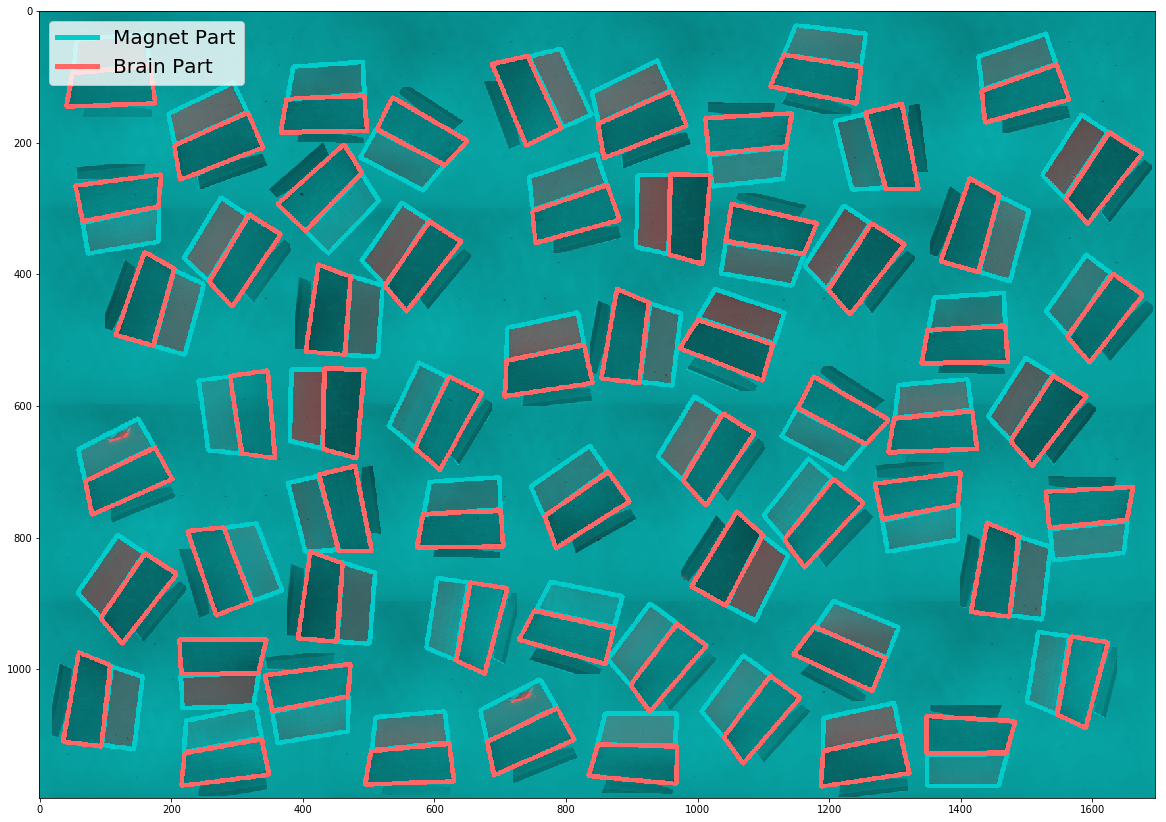

In [274]:
plt.figure(figsize=(20, 15))
plt.imshow(extrct_img)

plt.legend(handles=legend_elements, loc='upper left', fontsize=20)